In [13]:
import pandas as pd
from collections import Counter, defaultdict
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import umap
%matplotlib inline
datafile = 'dataset2.count.txt'
df = pd.read_csv(datafile, sep='\t')

In [14]:
df = df.set_index('Gene.Symbol')
cells = list(df.columns.values)

In [15]:
mat = np.array(df)
per_cell_sum = mat.sum(axis=1)
per_gene_sum = mat.sum(axis=0)
low_expr_thr = 100
high_expr_thr = 1000000
mat = mat[:, (per_gene_sum>=low_expr_thr) & (per_gene_sum<=high_expr_thr)]
mean_exp = mat.mean(axis=0)
std_exp = np.sqrt(mat.std(axis=0))
CV = std_exp/mean_exp
mat = mat[:, CV >= 1.5]
cells_expression = mat.sum(axis=1)
mat = mat[cells_expression>=100, :]
mat = np.log(mat+1)

In [18]:
def dendrogrammer(df, leaf_labels):
    D = df.values
    if len(leaf_labels) != len(D):
        D = np.transpose(D)
    Z = linkage(D, method='ward', metric='euclidean')
    plt.figure(figsize=(10, 10))
    ax = plt.subplot()
    plt.subplots_adjust(left=0.07, bottom = 0.3, right = 0.98, top = 0.95, wspace=0, hspace=0)
    plt.xlabel('Cell Line')
    plt.ylabel('Distance')
    
    dendrogram(Z, leaf_rotation=90., leaf_font_size=10., labels = leaf_labels)
    plt.savefig('dendrogram_nci60.png')

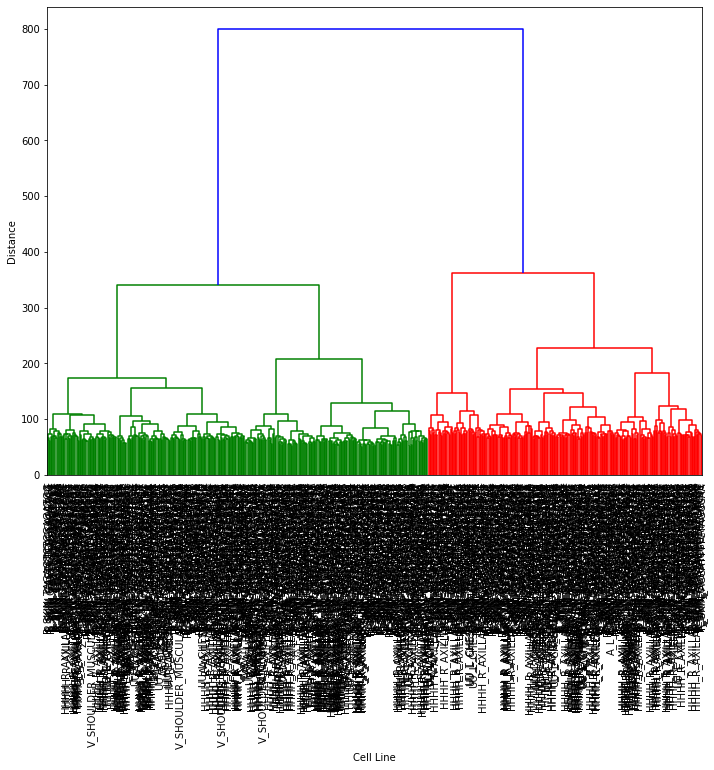

In [19]:
df = pd.DataFrame(mat,index=mat[:,0])
dendrogrammer(df, cells)

In [20]:
def PCAer(df):
 D = df.values
 D = np.transpose(D)
 pca = PCA(n_components= 50)
 pca.fit(D)
 projected = pca.fit_transform(D)
 return projected

In [35]:
from sklearn.cluster import KMeans
def kmeanser(df, k): 
    Dpc = PCAer(df)
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(Dpc)
    labels = kmeans.predict(Dpc)
    C = kmeans.cluster_centers_
    out = [Dpc, labels, C]
    print(np.bincount(kmeans.labels_))
    return out

In [36]:
[proj, labels, centroids] = kmeanser(df, 3)

[136 201 253]


ValueError: setting an array element with a sequence.

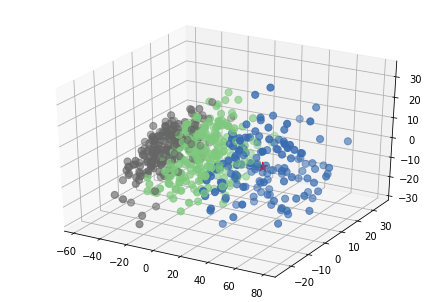

In [28]:
from mpl_toolkits.mplot3d import Axes3D
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1 = Axes3D(fig1)

ax1.scatter(proj[:,0], proj[:, 1], proj[:, 2], c=labels, s=50, cmap='Accent')

ax1.scatter(centroids[:,0], centroids[:, 1], centroids[:,2], c = 'red', s=100, marker='*', cmap='Accent')


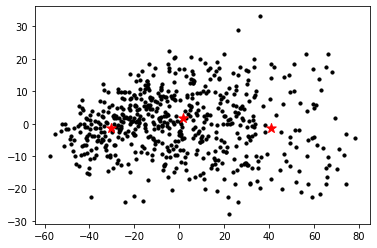

In [374]:
plt.scatter(proj[:,0], proj[:,2], s=10.0, color='black')
plt.scatter(centroids[:,0], centroids[:, 2], c = 'red', s = 100, marker='*', cmap='Accent')

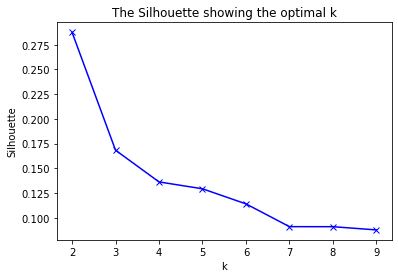

In [375]:
from sklearn.metrics import silhouette_score
K = range(2, 10)
sil = []
Dpc = PCAer(df)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(Dpc)
    labels = kmeans.predict(Dpc)
    sil.append(silhouette_score(Dpc, labels))
plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.title('The Silhouette showing the optimal k')
plt.show()

In [381]:
from scipy.spatial.distance import cdist
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df)
    kmeanModel.fit(df)
    #distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'), axis = 1))/df.shape[0])
    distortions.append(kmeanModel.inertia_)
print(distortions)

[4261452.850400253, 2609587.3986792946, 2072151.2291102142, 1842446.972326549, 1727576.3063238966, 1674567.6291417652, 1638910.5319379584, 1612116.3121806663, 1595880.7312405473]


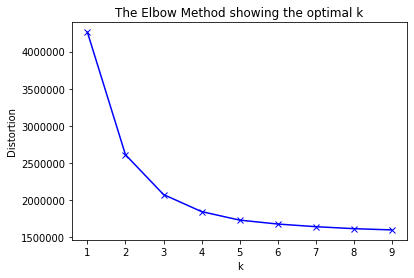

In [380]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()